In [65]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [66]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [67]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [68]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [69]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [70]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [71]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [72]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [73]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [74]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
start_date = dt.date(2017, 8, 23)

# Calculate the date one year from the last date in data set.
query_date = start_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= query_date)\
    .order_by(Measurement.date).all()

# Perform a query to sum up all values per day (to get one value per day) the filter and group by date. 
#sum_per_day = session.query(Measurement.date, func.sum(Measurement.prcp))\
    #filter(Measurement.date >= query_date)\
    #group_by(Measurement.date)\
   #.order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column and sort by date.
df = pd.DataFrame(prcp_data, columns = ["Date", "Precipitation"])
df.set_index("Date", inplace=True)

df        
        

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


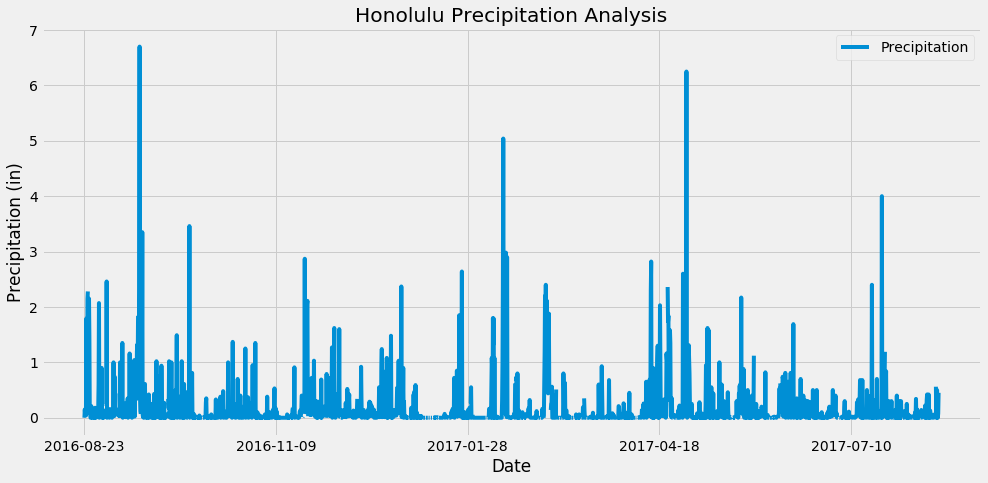

In [75]:
df=df.reset_index()
df.plot(x="Date",y="Precipitation",title ="Honolulu Precipitation Analysis", figsize = (15,7))
plt.xlabel("Date")
plt.ylabel("Precipitation (in)")
plt.savefig("Honolulu Precipitation Analysis.png")

In [76]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [77]:
# Design a query to calculate the total number stations in the dataset
station_total = session.query(Station.station).count
station_total()

9

In [78]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).all()

active_stations_df = pd.DataFrame(active_stations, columns = ["Station", "Count"])
active_stations_df.set_index("Station", inplace=True)

active_stations_df
    

,Count
Station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [79]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# ALTERNATE FUNCTION: lowest_temp = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter_by(station='USC00519281').order_by(Measurement.tobs).first()

lowest_temp = session.query(Measurement.station, Measurement.date, func.min(Measurement.tobs)).filter_by(station='USC00519281').all()
lowest_temp

[('USC00519281', '2013-01-16', 54.0)]

In [80]:
# ALTERNATE FUNCTION: highest_temp = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter_by(station='USC00519281').order_by(Measurement.tobs, acsending=False).first()

highest_temp = session.query(Measurement.station, Measurement.date, func.max(Measurement.tobs)).filter_by(station='USC00519281').all()
highest_temp

[('USC00519281', '2015-09-10', 85.0)]

In [81]:
avg_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).filter_by(station='USC00519281').all()
avg_temp

[('USC00519281', 71.66378066378067)]

In [82]:
# Using the most active station id, query the last 12 months of temperature observation data for this station 

last_year = session.query(Measurement.date, Measurement.tobs).filter_by(station='USC00519281').\
filter(Measurement.date <= '2017-08-23', Measurement.date >= '2016-08-23').all()

last_year_df = pd.DataFrame(last_year, columns = ['Date', 'Temp'])
last_year_df.set_index('Date', inplace=True)

last_year_df

,Temp
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


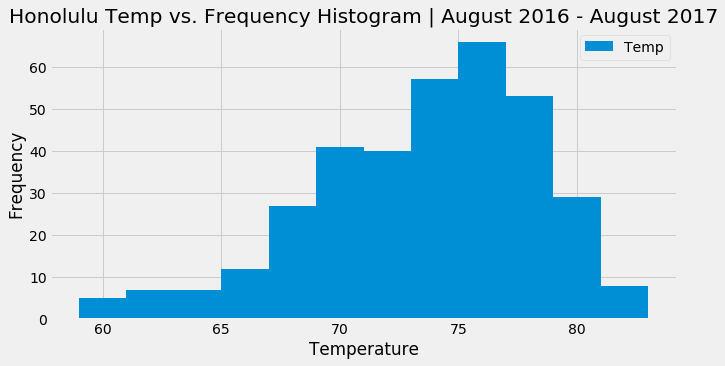

In [83]:
#Plot the results as a histogram
last_year_df.plot.hist(bins=12, title= 'Honolulu Temp vs. Frequency Histogram | August 2016 - August 2017', figsize=(10,5))
plt.xlabel("Temperature")
plt.legend(loc='upper right')
plt.savefig('Honolulu Temp vs. Frequency Histogram.png')
plt.show()

In [84]:
# Close Session
session.close()